In [3]:
import random
from string import ascii_uppercase, ascii_letters
from pprint import pprint
from copy import deepcopy
import dill
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
## from http://users.telenet.be/d.rijmenants/en/enigmatech.htm
entry = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'  #(rotor right side)   
I     = 'EKMFLGDQVZNTOWYHXUSPAIBRCJ'
II    = 'AJDKSIRUXBLHWTMCQGZNPYFVOE'
III   = 'BDFHJLCPRTXVZNYEIWGAKMUSQO'
IV    = 'ESOVPZJAYQUIRHXLNFTGKDCMWB'
V     = 'VZBRGITYUPSDNHLXAWMJQOFECK'
## Additional rotors used by Kriegsmarine M3 and M4 only:
VI    = 'JPGVOUMFYQBENHZRDKASXLICTW'
VII   = 'NZJHGRCXMYSWBOUFAIVLPEKQDT'
VIII  = 'FKQHTLXOCBJSPDZRAMEWNIUYGV'

## reflectors, standard army & airforce
contacts   = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' 
breflector = 'YRUHQSLDPXNGOKMIEBFZCWVJAT'
creflector = 'FVPJIAOYEDRZXWGCTKUQSBNMHL'

notches = {'I':'Q','II':'E','III':'V','IV':'J','V':'Z'}

In [5]:
raw_rotors = {'I':I, 'II':II, 'III':III, 'IV':IV, 'V':V}
print(raw_rotors)

{'I': 'EKMFLGDQVZNTOWYHXUSPAIBRCJ', 'II': 'AJDKSIRUXBLHWTMCQGZNPYFVOE', 'III': 'BDFHJLCPRTXVZNYEIWGAKMUSQO', 'IV': 'ESOVPZJAYQUIRHXLNFTGKDCMWB', 'V': 'VZBRGITYUPSDNHLXAWMJQOFECK'}


In [6]:
forward_rotors = {'I':[], 'II':[], 'III':[], 'IV':[], 'V':[]}
for k in forward_rotors.keys():
    forward_rotors[k] = [ascii_uppercase.index(c) for c in raw_rotors[k]]

# for k,v in forward_rotors.items():
#     print(k,':',v)

In [7]:
rev_rotors = {}

for r in raw_rotors.keys():
    working = {k:entry.index(v) for k,v in zip(raw_rotors[r],entry)}
    rev_rotors[r] = [working[k] for k in sorted(working.keys())]

# for k,v in rev_rotors.items():
#     print(k,':',v)

In [8]:
reflectors = {'B': {k:v for k,v in zip(entry, breflector)}, 'C': {k:v for k,v in zip(entry, creflector)}}
# print(reflectors)

In [9]:
class Enigma3:
    
    def __init__(self,left_rotor,middle_rotor,right_rotor,reflector,menu_link='ZZZ'):
        """rotors must be strings referring to either ['I','II','III','IV','V']
        reflector must be string, one of either ['B','C']"""
        
        self.right_rotor = right_rotor
        self.middle_rotor = middle_rotor
        self.left_rotor = left_rotor
        self.reflector = reflectors[reflector]
        self.menu_link = menu_link
        self.middle_notch = entry.index(notches[self.middle_rotor])   ## point if right rotor reaches will trigger middle rotor to step
        self.left_notch = entry.index(notches[self.left_rotor])  ## point if middle rotor reaches will trigger left rotor to step
        self.pos_left_rotor, self.pos_mid_rotor, self.pos_rgt_rotor = (ascii_uppercase.index(m) for m in menu_link.upper())
        self.in_status = {char:0 for char in entry}
        self.out_status = {char:0 for char in entry}
        self.current_position = menu_link
        self.record = {}

        
    def once_thru_scramble(self,start_character, direction, first_rotor, pos1, second_rotor, pos2, 
                       third_rotor, pos3):
        """ start_character must be single ASCII character A-Z
        direction is either 'forward' or 'back' """
        if direction == 'forward':
            usedict = {k:v for k,v in forward_rotors.items()}
        elif direction == 'back':
            usedict = {k:v for k,v in rev_rotors.items()}
        else:
            print('only forward or back for direction')
            return 'wtf'

        start_character = start_character.upper()
        entry_pos = entry.index(start_character)
        fst_pos_modifier = (26 + pos1 - 0)%26
        fst_in = (entry_pos + fst_pos_modifier)%26
        fst_out = usedict[first_rotor][fst_in]
        ch1o = entry[fst_out]

        scd_pos_modifier = (26 + pos2 - pos1)%26
        scd_in = (fst_out + scd_pos_modifier)%26
        ch2i = entry[scd_in]
        scd_out = usedict[second_rotor][scd_in]
        ch2o = entry[scd_out]

        thd_pos_modifier = (26 + pos3 - pos2)%26
        thd_in = (scd_out + thd_pos_modifier)%26
        ch3i = entry[thd_in]
        thd_out = usedict[third_rotor][thd_in]
        ch3o = entry[thd_out]

#         if direction == 'forward':
#             print(f"{start_character} -> (RR out) {ch1o} -> (MR in) {ch2i} -> (MR out) {ch2o} -> (LR in) {ch3i} -> (LR out) {ch3o}")
#         elif direction == 'back':
#             print(f"{start_character} -> (LR out) {ch1o} -> (MR in) {ch2i} -> (MR out) {ch2o} -> (RR in) {ch3i} -> (RR out) {ch3o}")

        return ch3o
    
    def full_scramble(self,in_ch):
        in_ch = in_ch.upper()
        left_rotor = self.left_rotor
        middle_rotor = self.middle_rotor
        right_rotor = self.right_rotor
        rflector = self.reflector
        ## first run right to left through scrambler
        forward_run = self.once_thru_scramble(in_ch, direction='forward', first_rotor=right_rotor, pos1=self.pos_rgt_rotor, 
                                              second_rotor=middle_rotor, pos2=self.pos_mid_rotor, 
                                              third_rotor=left_rotor, pos3=self.pos_left_rotor)

        ## reflector back around for return
        rfi_pos_mod = (26 + 0 - self.pos_left_rotor)%26    ## the '0' is there to matching formatting of other position modifiers - reflector is not moved so it will always be 0
        rf_in = (entry.index(forward_run) + rfi_pos_mod)%26
        chri = entry[rf_in]
        mirrored = rflector[chri]

#         print(f"{forward_run} -> {chri} (into reflector) -> {mirrored} (reflected out)")

        ## second run back left to right thru scrambler
        back_run = self.once_thru_scramble(mirrored, direction='back', first_rotor=left_rotor, pos1=self.pos_left_rotor, 
                                      second_rotor=middle_rotor, pos2=self.pos_mid_rotor, third_rotor=right_rotor, pos3=self.pos_rgt_rotor)

        bk_out = entry.index(back_run)
        bko_pos_mod = (26 + 0 - self.pos_rgt_rotor)%26  ## as above, '0' just reflects that the entry interface doesn't move
        bk_final = (bk_out + bko_pos_mod)%26
        final = entry[bk_final]
#         print('RR back out:  ', back_run, '-->', final)
#         print(in_ch,"-->",final)
        return final
    
    def rotor_step(self,rotor_position):
        """"""
        if rotor_position == 25:
            rotor_position = 0
        else:
            rotor_position += 1
        return rotor_position
    
    
    def translate_current_position(self):
        self.current_position = ''
        for pos in self.pos_left_rotor,self.pos_mid_rotor,self.pos_rgt_rotor:
            self.current_position += entry[pos]
            
            
    def step_enigma(self):
        """Just acts on itself, steps the rotors"""
        
#         print(f"Lpos={self.pos_left_rotor}, Mpos={self.pos_mid_rotor}, Rpos={self.pos_rgt_rotor}")
        if self.pos_rgt_rotor == self.middle_notch and self.pos_mid_rotor == self.left_notch:
            self.pos_rgt_rotor = self.rotor_step(self.pos_rgt_rotor)
            self.pos_mid_rotor = self.rotor_step(self.pos_mid_rotor)
            self.pos_left_rotor = self.rotor_step(self.pos_left_rotor)
            print('--- left & middle rotor step')
        elif self.pos_rgt_rotor == self.middle_notch:
            self.pos_rgt_rotor = self.rotor_step(self.pos_rgt_rotor)
            self.pos_mid_rotor = self.rotor_step(self.pos_mid_rotor)
            print('--- middle rotor step ---')
        else:
            self.pos_rgt_rotor = self.rotor_step(self.pos_rgt_rotor)
        self.translate_current_position()
        print(f"Lpos={self.pos_left_rotor}, Mpos={self.pos_mid_rotor}, Rpos={self.pos_rgt_rotor}")


        
    def only_ascii(self,instring):
        """strips out anything that's not an ascii character (i.e a-z alphabet character), capitalises"""
        newstring = ''
        for character in instring:
            if character in ascii_letters:
                newstring += character.upper()
        return newstring

    def enigmatise(self,tocode, startset='AAA'):
        encoded = ''

        tocode = self.only_ascii(tocode)
        
        self.pos_left_rotor, self.pos_mid_rotor, self.pos_rgt_rotor = (ascii_uppercase.index(s) for s in startset.upper())
        
        for i,c in enumerate(tocode):
            print('in:    ', c)
            self.step_enigma()

            print('rp = ', self.pos_rgt_rotor, 'mp = ', self.pos_mid_rotor, 'lp = ', self.pos_left_rotor)
            
            out = self.full_scramble(c)
            print('out:   ', out,'\n')
            
            encoded += out
            self.translate_current_position()
            self.record[i] = {'in':c,'out':out,'current_pos':self.current_position}

        return encoded
            



In [10]:
eg1 = Enigma3('I','II','III','B')

In [11]:
word = 'oh what a beautiful morning oh what a beautiful day i have a wonderful feeling everthings going my way'

In [12]:
## 'INH' gives 3 loops
opcode = 'INH'   
## try 'PJM' - gives some strange results, need to work on sorting out whats a loop and what isn't better
## operator set starting position, traditionally different for each new message

In [13]:
igged = eg1.enigmatise(word, startset=opcode)
igged

in:     O
Lpos=8, Mpos=13, Rpos=8
rp =  8 mp =  13 lp =  8
out:    B 

in:     H
Lpos=8, Mpos=13, Rpos=9
rp =  9 mp =  13 lp =  8
out:    K 

in:     W
Lpos=8, Mpos=13, Rpos=10
rp =  10 mp =  13 lp =  8
out:    L 

in:     H
Lpos=8, Mpos=13, Rpos=11
rp =  11 mp =  13 lp =  8
out:    X 

in:     A
Lpos=8, Mpos=13, Rpos=12
rp =  12 mp =  13 lp =  8
out:    U 

in:     T
Lpos=8, Mpos=13, Rpos=13
rp =  13 mp =  13 lp =  8
out:    V 

in:     A
Lpos=8, Mpos=13, Rpos=14
rp =  14 mp =  13 lp =  8
out:    T 

in:     B
Lpos=8, Mpos=13, Rpos=15
rp =  15 mp =  13 lp =  8
out:    I 

in:     E
Lpos=8, Mpos=13, Rpos=16
rp =  16 mp =  13 lp =  8
out:    F 

in:     A
Lpos=8, Mpos=13, Rpos=17
rp =  17 mp =  13 lp =  8
out:    X 

in:     U
Lpos=8, Mpos=13, Rpos=18
rp =  18 mp =  13 lp =  8
out:    S 

in:     T
Lpos=8, Mpos=13, Rpos=19
rp =  19 mp =  13 lp =  8
out:    G 

in:     I
Lpos=8, Mpos=13, Rpos=20
rp =  20 mp =  13 lp =  8
out:    Y 

in:     F
Lpos=8, Mpos=13, Rpos=21
rp =  21 mp =  13 lp

'BKLXUVTIFXSGYDHMJEWTORZVSNTPBMZMXAIPTETNEDPNEWAUDTESYYQJDEIFXYIWUCQPPQWYROJGBCTCLNET'

In [14]:
# eg1.record

In [15]:
print(eg1.left_notch,eg1.middle_notch)

16 4


## Have now set up function 'enigmatise' to encode a message in enigma format
### Next step is to work on decoding it!

In [16]:
igged

'BKLXUVTIFXSGYDHMJEWTORZVSNTPBMZMXAIPTETNEDPNEWAUDTESYYQJDEIFXYIWUCQPPQWYROJGBCTCLNET'

In [17]:
reword = eg1.enigmatise(igged, startset=opcode)
reword

in:     B
Lpos=8, Mpos=13, Rpos=8
rp =  8 mp =  13 lp =  8
out:    O 

in:     K
Lpos=8, Mpos=13, Rpos=9
rp =  9 mp =  13 lp =  8
out:    H 

in:     L
Lpos=8, Mpos=13, Rpos=10
rp =  10 mp =  13 lp =  8
out:    W 

in:     X
Lpos=8, Mpos=13, Rpos=11
rp =  11 mp =  13 lp =  8
out:    H 

in:     U
Lpos=8, Mpos=13, Rpos=12
rp =  12 mp =  13 lp =  8
out:    A 

in:     V
Lpos=8, Mpos=13, Rpos=13
rp =  13 mp =  13 lp =  8
out:    T 

in:     T
Lpos=8, Mpos=13, Rpos=14
rp =  14 mp =  13 lp =  8
out:    A 

in:     I
Lpos=8, Mpos=13, Rpos=15
rp =  15 mp =  13 lp =  8
out:    B 

in:     F
Lpos=8, Mpos=13, Rpos=16
rp =  16 mp =  13 lp =  8
out:    E 

in:     X
Lpos=8, Mpos=13, Rpos=17
rp =  17 mp =  13 lp =  8
out:    A 

in:     S
Lpos=8, Mpos=13, Rpos=18
rp =  18 mp =  13 lp =  8
out:    U 

in:     G
Lpos=8, Mpos=13, Rpos=19
rp =  19 mp =  13 lp =  8
out:    T 

in:     Y
Lpos=8, Mpos=13, Rpos=20
rp =  20 mp =  13 lp =  8
out:    I 

in:     D
Lpos=8, Mpos=13, Rpos=21
rp =  21 mp =  13 lp

'OHWHATABEAUTIFULMORNINGOHWHATABEAUTIFULDAYIHAVEAWONDERFULFEELINGEVERTHINGSGOINGMYWAY'

In [18]:
print(igged)
print(reword)

BKLXUVTIFXSGYDHMJEWTORZVSNTPBMZMXAIPTETNEDPNEWAUDTESYYQJDEIFXYIWUCQPPQWYROJGBCTCLNET
OHWHATABEAUTIFULMORNINGOHWHATABEAUTIFULDAYIHAVEAWONDERFULFEELINGEVERTHINGSGOINGMYWAY


In [19]:
crib = 'OHWHATABEAUTIFULDAY'
lncrib = len(crib)

In [20]:
reword[23:23+lncrib]

'OHWHATABEAUTIFULDAY'

#### Have chosen a crib (how to do this automatically will be a bigger problem later on)
#### first step is to find positions in the encoded text ('igged') that could feasibly contain the crib words, as defined by not encoding a letter as itself

In [21]:

# status_of_crib_indexes = {k:True for k in range(len(igged))}
# # print(status_of_crib_indexes)
# for num, letter in enumerate(igged[:len(igged)-lncrib]):
#     trange = range(num,num+lncrib)
#     tcrib = igged[num:num+lncrib]
#     for c, t in zip(crib, tcrib):
#         if c == t:
#             status_of_crib_indexes[num] = False
    
        
# print(status_of_crib_indexes)
# maybes = [k for k,v in status_of_crib_indexes.items() if v == True]
# print(maybes)

#### Looks like there are many potential positions. This will be a problem later in the piece when trying to do more unknown messages. Will test out a method for a crib that I know is in the correct position 

In [22]:
mcrib = igged[23:23+lncrib]
print(crib)
print(mcrib)

OHWHATABEAUTIFULDAY
VSNTPBMZMXAIPTETNED


In [37]:
class MenuMaker:
    
    def __init__(self,crib,encoded_crib):
        self.crib = crib
        self.encoded_crib = encoded_crib
        
    def do_pairs(self):
        self.pairs = {i:{c,m} for i,c,m in zip(range(len(self.crib)), self.crib, self.encoded_crib)}
        self.links = {character:len([pair for pair in self.pairs.values() if character in pair]) for character in entry}   
#         print(links)
        self.hilinks = {k:v for k,v in self.links.items() if v > 0}
        ### actually think I should make hilinks just a ranked(sorted) list of characters from highest to lowest
        self.mostlinks = sorted(self.hilinks.values(),reverse=True)[0]
        self.best_characters = [k for k,v in self.hilinks.items() if v == self.mostlinks]
        
        self.hipairs = {}
        for character in self.hilinks.keys():
            hset = {k:list(pair) for k,pair in self.pairs.items() if character in pair}
            newresult = {}
            for k,v in hset.items():
                v.remove(character)
                if v[0] in self.hilinks.keys():
                    newresult[k] = v[0]
        #     print('hset:      ',hset)
        #     print('newresult: ',newresult)
            if len(newresult) > 0:
                self.hipairs[character] = newresult
        #     hipairs[character] = {k:pair.remove(character) for k,pair in pairs.items() if character in pair}
        ## maybe try a comprehension again later, involves a few steps...

    def make_connections(self,starting_character, indict, loops={}, deadends={}, itr = 1, tracking_len=0):
        """for sorting through a hipairs dictionary of letters of interest and their corresponding paired letters. 
        Used with a WHILE loop, can recursively search through 'chains' or paths that a letter sequence can take 
        by following pairs from one letter to the next. Looks for 'loops', where a chain path can return to its original
        starting letter. Records other chains as deadends
        """
        if itr == 1:
            working_dict = {k+tracking_len:v for k,v in deepcopy(indict).items()}
            indict = deepcopy(working_dict)
        else:
            working_dict = deepcopy(indict)
#         print(working_dict)
        for iD,chain in indict.items():
#             print('iD-chain',iD,chain)
            current_end = chain[-1]
            letters_that_current_end_is_connected_to = self.hipairs[current_end]
            for jid,conxn in enumerate(letters_that_current_end_is_connected_to.values()):
                key = round(iD+jid/10**itr,5)   
#                 print('key',key)
                if conxn != current_end:
                    working_dict[key] = indict[iD] + conxn
#         print('all connections')
#         pprint(working_dict)

        dx={}
        for kid,chain in working_dict.items():
            if chain[-1] == chain[-3]:# and len(v):
                chain = chain[:-1]
                deadends[kid] = chain
            elif chain[-1] == starting_character and len(chain) > 3:   ## ie we're legit back to the start after a loop
                loops[kid] = chain
            else:
                dx[kid] = chain
#         print('useful connections: ')
#         pprint(dx)
#         print('loops:')
#         pprint(loops)
        return dx, loops, deadends

    def find_loops(self,starting_character):
        working_dict = {i+0.0:starting_character for i in range(len(self.hipairs[starting_character]))}
        for i,v in zip(range(len(self.hipairs[starting_character])), self.hipairs[starting_character].values()):
            working_dict[i] += v

        run = 1
        tracker = len(self.found_loops)
        while len(working_dict) > 0:
            working_dict, self.found_loops, self.dead_ends = self.make_connections(starting_character, working_dict,self.found_loops,self.dead_ends,run,tracker)
            run +=1

        
    def rationalise_to_list(self,indict):
        """goes through list values of results from find_loops, turns into single large list,
        gets rid of any elements that are mirror images of each other (keeping one unique)"""
        invals = list(set(indict.values()))
        for i,loop in enumerate(invals):
            test = deepcopy(invals)
            test[i] = loop[::-1]
            test = list(set(test))
            if len(test) != len(invals):
                invals[i] = loop[::-1]
        invals = list(set(invals))

        return invals
            
    def unsub_list(self,inlist):
        """when given a list of strings from rationalise_to_list, will get rid of any elements which are a
        subset of another larger element, leaving only the unique strings"""
        inlist.sort()
        unique = []
        for i in range(len(inlist)-1):
            chain = inlist[i]
            nxt_chain = inlist[i+1]
            if chain not in nxt_chain:
                unique.append(chain)
        unique.append(inlist[-1])

        return unique
    
    def get_smallest_loop(self,inlist):
        """like unsub list but in reverse, for loops"""
        inlist = sorted(inlist,reverse=True)
        unique = deepcopy(inlist)
        for chain in inlist:
            for other_chain in inlist:
                if len(chain) < len(other_chain):
                    smaller = chain
                    bigger = other_chain
                else:
                    smaller = other_chain
                    bigger = chain
                test = ((smaller in bigger) or (smaller[::-1] in bigger))
                if smaller == bigger:
                    test = False
                print(smaller,bigger,test)
                if test and bigger in unique and smaller in unique:
                    unique.remove(bigger)
                    print('removed',bigger)
                    print(unique)

        return unique
    
    def lose_redundant_deadends(self):
        """should be applied after dead ends have been rationalised and unsubbed"""
        check_against_these_loops = set(self.found_loops)
        final_uniq_dends = deepcopy(self.dead_ends)
        for uchain in self.dead_ends:
            for eachloop in check_against_these_loops:
                if (uchain in eachloop or uchain[::-1] in eachloop or eachloop in uchain or eachloop[::-1] in uchain) and uchain in final_uniq_dends:
                    final_uniq_dends.remove(uchain)

        self.dead_ends = final_uniq_dends
    
    def process_stuff(self):
        self.do_pairs()
        self.found_loops = {}
        self.dead_ends = {}
        for char in self.best_characters:
#             print('############ run for ',char)
            self.find_loops(char)
        self.dead_ends = self.rationalise_to_list(self.dead_ends)
        print('dends b4',self.dead_ends)
        self.dead_ends = self.unsub_list(self.dead_ends)
        print('dends after',self.dead_ends)
        self.found_loops = self.rationalise_to_list(self.found_loops)
        print('loops b4',self.found_loops)
        self.found_loops = self.get_smallest_loop(self.found_loops)
        print('loops after',self.found_loops)
        self.lose_redundant_deadends()
        
    def loop_to_menu(self,mainloop=0):
        if mainloop == 0:
            mainloop = self.found_loops[0]
        
        for i,char in enumerate(mainloop[:-1]):
            next_char = mainloop[i+1]
            wdict = self.hipairs[char]
        #     print(wdict)
            position = [k for k,v in wdict.items() if v == next_char][0]
            ### note that I'm just picking the first one where there are double (or more) linkages
            ### not sure if this matters for now or if its better to somehow include both linkages in the menu
            ### revisit later depending on bombe methodology
        #     print(position)
#             print(i,char,next_char,position)
            self.menu[position] = {'in':char, 'out':next_char, 'menu_link':position}
            print(f"added item from loop '{mainloop}' to menu {position} : {self.menu[position]}")
            
    def add_deadends_to_menu(self):
        for ends in sorted(mm.dead_ends,reverse=True):
            current_len = len(self.menu)
        #     print(current_len)
            for i,char in enumerate(ends[:-1]):
                if len(self.menu) >= 12:
                    pass
                else:
                    next_char = ends[i+1]
            #         print(i,char,next_char)
                    wdict = self.hipairs[char]
                    position = [k for k,v in wdict.items() if v == next_char][0]
                    self.menu[position] = {'in':char, 'out':next_char, 'menu_link':position}
                    print(f"added item from deadend '{ends}' to menu {position} : {self.menu[position]}")
    
    def configure_menu(self):
        test_char = self.found_loops[0][0]
#         print(test_char)
        self.menu['config'] = {}
        self.menu['config']['test_char'] = test_char
        self.menu['config']['menu_link'] = 'QQQ'
        self.menu['config']['in'] = test_char
        self.menu['config']['out'] = test_char
        self.menu['config']['conx_in'] = {}
        self.menu['config']['conx_out'] = {}
        
    
    def connections_add_to_menu(self):
        ## this part adds in blank conx_in/out dicts and converts position to menulink 3-letter ZZ code
        for k,m in self.menu.items():
            if k == 'config':
                pass
            else:
                l = m['menu_link']
                l = entry[l-1]
                l = 'ZZ' + l
            #     print(l)
                self.menu[k]['menu_link'] = l
                self.menu[k]['conx_in'] = {}
                self.menu[k]['conx_out'] = {}
            
        ## this part does the heavy lifting of populating the connections for each menu item
        for pos,mdict in self.menu.items():
            sin = mdict['in']
            for k,v in self.menu.items():
                if k == pos or k == 'config':
                    pass
                elif v['in'] == sin:
                    self.menu[pos]['conx_in'][k] = 'in'
                elif v['out'] == sin:
                    self.menu[pos]['conx_in'][k] = 'out'

            sout = mdict['out']
            for k,v in self.menu.items():
                if k == pos or k == 'config':
                    pass
                elif v['in'] == sout:
                    self.menu[pos]['conx_out'][k] = 'in'
                elif v['out'] == sout:
                    self.menu[pos]['conx_out'][k] = 'out'
        
    def prep_menu(self):
        self.menu= {}
        for loop in self.found_loops:
            self.loop_to_menu(mainloop=loop)
        self.add_deadends_to_menu()
        self.configure_menu()
        self.connections_add_to_menu()

        
    def network_graph(self,reset_pos=True):
        """Using networkx package to display connections of menu letters"""
        edges = {k:list(v) for k,v in self.pairs.items()}
        edges = [(v[0],v[1],{'label':str(k)}) for k,v in edges.items()]
        self.MultiGraph = nx.MultiGraph()
        self.MultiGraph.add_edges_from(edges)
        
        fig, ax = plt.subplots(figsize=(8,8))
        
        if reset_pos == False:
            pass
        else:
            self.pos = nx.spring_layout(self.MultiGraph,k=0.4,scale=1)

        nx.draw_networkx(self.MultiGraph,pos=self.pos)

        labels = nx.get_edge_attributes(self.MultiGraph,'label')
        labels = {(k[0],k[1]):v for k,v in labels.items()}  ## doesnt' seem to be able to deal with labels for multiples edges
        edge_labels = nx.draw_networkx_edge_labels(self.MultiGraph,pos=self.pos,edge_labels=labels)
        plt.show(fig)

In [38]:
mm = MenuMaker(crib,mcrib)

In [39]:
mm.process_stuff()


dends b4 ['THS', 'TIPAX', 'MEUAPIT', 'TIPAMEA', 'AM', 'TH', 'TIPAU', 'AME', 'TB', 'UA', 'AUE', 'APITB', 'API', 'APITBZ', 'TIPAEU', 'AE', 'TBZ', 'TIPAEMAE', 'TF', 'AP', 'APITL', 'EAPIT', 'TIPAEM', 'APITHS', 'TIP', 'MEA', 'AX', 'TIPAUEA', 'UEA', 'AMEU', 'TIPAM', 'TIPAMEU', 'TIPAME', 'TI', 'EAUEAPIT', 'FTIPA', 'APIT', 'LT', 'HTIPA', 'MEUA', 'EUAPIT']
dends after ['AE', 'AMEU', 'APITBZ', 'APITHS', 'APITL', 'AUE', 'AX', 'EAUEAPIT', 'EUAPIT', 'FTIPA', 'HTIPA', 'LT', 'MEA', 'MEUAPIT', 'TBZ', 'TF', 'THS', 'TIPAEMAE', 'TIPAEU', 'TIPAMEA', 'TIPAMEU', 'TIPAUEA', 'TIPAX', 'UA', 'UEA']
loops b4 ['AEMA', 'AUEMA', 'AMEA', 'AMEUA', 'AEUA']
AUEMA AUEMA False
AMEUA AUEMA True
removed AUEMA
['AMEUA', 'AMEA', 'AEUA', 'AEMA']
AMEA AUEMA False
AEUA AUEMA False
AEMA AUEMA False
AUEMA AMEUA True
AMEUA AMEUA False
AMEA AMEUA False
AEUA AMEUA False
AEMA AMEUA False
AMEA AUEMA False
AMEA AMEUA False
AMEA AMEA False
AEUA AMEA False
AEMA AMEA True
removed AMEA
['AMEUA', 'AEUA', 'AEMA']
AEUA AUEMA False
AEUA AMEUA 

In [40]:
print(mm.found_loops)
print(mm.dead_ends)

['AMEUA', 'AEUA', 'AEMA']
['APITBZ', 'APITHS', 'APITL', 'AX', 'EUAPIT', 'FTIPA', 'HTIPA', 'LT', 'MEUAPIT', 'TBZ', 'TF', 'THS', 'TIPAEU', 'TIPAMEU', 'TIPAX']


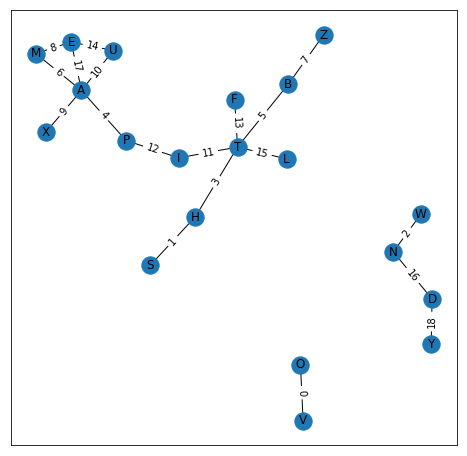

In [52]:
mm.network_graph(reset_pos=False)

In [53]:
mm.prep_menu()

added item from loop 'AMEUA' to menu 6 : {'in': 'A', 'out': 'M', 'menu_link': 6}
added item from loop 'AMEUA' to menu 8 : {'in': 'M', 'out': 'E', 'menu_link': 8}
added item from loop 'AMEUA' to menu 14 : {'in': 'E', 'out': 'U', 'menu_link': 14}
added item from loop 'AMEUA' to menu 10 : {'in': 'U', 'out': 'A', 'menu_link': 10}
added item from loop 'AEUA' to menu 17 : {'in': 'A', 'out': 'E', 'menu_link': 17}
added item from loop 'AEUA' to menu 14 : {'in': 'E', 'out': 'U', 'menu_link': 14}
added item from loop 'AEUA' to menu 10 : {'in': 'U', 'out': 'A', 'menu_link': 10}
added item from loop 'AEMA' to menu 17 : {'in': 'A', 'out': 'E', 'menu_link': 17}
added item from loop 'AEMA' to menu 8 : {'in': 'E', 'out': 'M', 'menu_link': 8}
added item from loop 'AEMA' to menu 6 : {'in': 'M', 'out': 'A', 'menu_link': 6}
added item from deadend 'TIPAX' to menu 11 : {'in': 'T', 'out': 'I', 'menu_link': 11}
added item from deadend 'TIPAX' to menu 12 : {'in': 'I', 'out': 'P', 'menu_link': 12}
added item f

In [54]:
len(mm.menu)

13

In [55]:
mm.menu

{6: {'in': 'A',
  'out': 'M',
  'menu_link': 'ZZF',
  'conx_in': {10: 'out', 17: 'in', 4: 'out', 9: 'in'},
  'conx_out': {8: 'in'}},
 8: {'in': 'M',
  'out': 'E',
  'menu_link': 'ZZH',
  'conx_in': {6: 'out'},
  'conx_out': {14: 'in', 17: 'out'}},
 14: {'in': 'E',
  'out': 'U',
  'menu_link': 'ZZN',
  'conx_in': {8: 'out', 17: 'out'},
  'conx_out': {10: 'in'}},
 10: {'in': 'U',
  'out': 'A',
  'menu_link': 'ZZJ',
  'conx_in': {14: 'out'},
  'conx_out': {6: 'in', 17: 'in', 4: 'out', 9: 'in'}},
 17: {'in': 'A',
  'out': 'E',
  'menu_link': 'ZZQ',
  'conx_in': {6: 'in', 10: 'out', 4: 'out', 9: 'in'},
  'conx_out': {8: 'out', 14: 'in'}},
 11: {'in': 'T',
  'out': 'I',
  'menu_link': 'ZZK',
  'conx_in': {3: 'in', 13: 'in'},
  'conx_out': {12: 'in'}},
 12: {'in': 'I',
  'out': 'P',
  'menu_link': 'ZZL',
  'conx_in': {11: 'out'},
  'conx_out': {4: 'in'}},
 4: {'in': 'P',
  'out': 'A',
  'menu_link': 'ZZD',
  'conx_in': {12: 'out'},
  'conx_out': {6: 'in', 10: 'out', 17: 'in', 9: 'in'}},
 9: {

In [56]:
with open('menu_transfer.pickle', 'wb') as outfile:
    dill.dump(mm.menu,outfile)

In [29]:
# e2g = Enigma3('I','II','III','B',menu_link='IOA')

In [30]:
# for i in range(15):
#     e2g.step_enigma()
#     print(e2g.current_position)